# Optimizing a Polymer Compound for Strength and Density

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sgbaird/honegumi/blob/main/docs/curriculum/tutorials/mobo/mobo-tutorial.ipynb)

In [ ]:
try:
    import google.colab
    %pip install ax-platform
except:
    print("Not running in Google Colab")



Imagine you work at a custom materials solutions company that specializes in creating polymer compounds for various applications. A customer has requested a polymer formulation with high strength and a high biodegradability score. The customer is unsure of the tradeoff between the two properties but knows that the target application will require a strength of at least 70 MPa. As the customer is concerned about the toxicitiy and biodegradability of the polymer, they have limited you to a set of **five** thermoplastic monomers that can be used in the formulation.

You believe Bayesian optimization can help you in this task and decide to put together an optimization script using Honegumi to help solve this problem.

Taking note of available composition and process parameters you decide to restrict your design space to the following:

| | **Parameter Name** | **Bounds**  |
|------|--------------------|-------------|
| x1   | Monomer A          | [0, 1]       |
| x2   | Monomer B          | [0, 1]       |
| x3   | Monomer C          | [0, 1]       |
| x4   | Monomer D          | [0, 1]       |
| x5   | Monomer E          | [0, 1]       |
| x6   | Extrusion Rate     | [0.01, 0.1] |
| x7   | Temperature        | [120, 200]  |

To help find a solution quickly, you dig up some data on these polymer systems in the literature and decide to use them to help improve the surrogate model. While none of these meet the customer requirement, you think they might at least help tell your model where NOT to look. The collected data is as follows:

| **x1** | **x2** | **x3** | **x4** | **x5** | **x6** | **x7** | **Strength** | **BioDeg** |
|--------|--------|--------|--------|--------|--------|--------|--------------|------------|
| 0.3    | 0.2    | 0.1    | 0.0    | 0.4    | 0.05   | 150    | 43.73        | 1.81       |
| 0.0    | 0.0    | 0.3    | 0.7    | 0.0    | 0.1    | 160    | 25.79        | 3.83       |
| 0.2    | 0.2    | 0.2    | 0.2    | 0.2    | 0.09   | 184    | 41.37        | 2.29       |

A dummy objective function that returns outputs for each property has been constructed in the code cell below. This functions aims to emulate the results of experimental trials under different inputs. Although we can easily find optimal values using the equations, we will pretend that the objective function is unknown and use a Bayesian optimization approach to find the optimal set of input parameters instead.

In [6]:
import numpy as np

def polymer_properties(x1, x2, x3, x4, x5, x6, x7):
    """
    Calculates the strength and biodegradability properties of a polymer based 
    on a set of given input parameters.

    Parameters:
    x1 (float): volume fraction of monomer 1. Range: [0.0, 1.0].
    x2 (float): volume fraction of monomer 2: [0.0, 1.0].
    x3 (float): volume fraction of monomer 3: [0.0, 1.0].
    x4 (float): volume fraction of monomer 4: [0.0, 1.0].
    x5 (float): volume fraction of monomer 5: [0.0, 1.0].
    x6 (float): the polymer extrusion rate. Range: [0.01, 0.1].
    x7 (float): the processsing temperature. Range: [120.0, 200.0].

    Returns:
    dict: calculated strength and biodegradability properties of polymer in form:
          {
              "strength": float,
              "biodegradability": float
          }
    """
    strength = float(
        np.exp(-(50*(x1-0.5)**2)) +
        np.exp(-(5*(x2-0.4)**2)) -
        0.8*x3 +
        np.exp(-(300*(x4-0.1)**2)) -
        0.3*x5**2 +
        np.exp(-(2000*(x6-0.025)**2)) +
        1/(1+np.exp(-(x7-137)/15))
    )

    biodegradability = float(
        -1/(1+np.exp(-(x1-0.1)/0.1)) + 1 +
        -1/(1+np.exp(-(x2-0.3)/0.1)) + 1 +
        x3**2 +
        x4 +
        1/(1+np.exp(-(x5-0.7)/0.075)) +
        10*x6 +
        -(x7/200)**2+1
    )

    return {"strength" : strength*25, "biodegradability" : biodegradability*5}

## Applying Honegumi

We will now use the [Honegumi website](https://honegumi.readthedocs.io/en/latest/) to generate a script that will help us optimize the polymer parameters. From the description, we observe that our problem is a **multi objective** optimization problem with a **constraint on the fractional sum of monomer components** and a **custom threshold** on the optimized strength. Additionally, we would like to include some **historical data** in our model training. To create an optimization script for this problem, we select the following options:

![Selection.jpg](freq-vs-bayes-hg-selection.jpeg)

The Honegumi generated optimization script will provide a framework for our optimization campaign that we can modify to suit our specific problem needs. In the code sections below, we will make several modifications to this generated script to make it compatible with our problem.

## Modifying the Code for Our Problem

We can modify this code to suit our problem with a few simple modifications. Wherever a modification has been made to the code, a comment starting with `# CHANGE:` has been added along with a brief description of the change.

In [12]:
import numpy as np
from ax.service.ax_client import AxClient, ObjectiveProperties


import pandas as pd

obj1_name = "strength" # CHANGE: add name of first objective
obj2_name = "biodegradability" # CHANGE: add name of first objective


# CHANGE: remove the moo_branin dummy objective function, we will use the above function

# CHANGE: update the total quantity for the composition constraint
total = 1.0

# CHANGE: add the historical data that was pulled from the literature
X_train = pd.DataFrame(
    [
        {"x1": 0.3, "x2": 0.2, "x3": 0.1, "x4": 0.0, "x5": 0.4, "x6": 0.05, "x7": 150.0},
        {"x1": 0.0, "x2": 0.0, "x3": 0.3, "x4": 0.7, "x5": 0.0, "x6": 0.1, "x7": 160.0},
        {"x1": 0.2, "x2": 0.2, "x3": 0.2, "x4": 0.2, "x5": 0.2, "x6": 0.09, "x7": 184.0},
    ]
)

# CHANGE: calculate the y_train values using the polymer_properties function
y_train = [polymer_properties(**row[1]) for row in X_train.iterrows()]

# Define the number of training examples
n_train = len(X_train)

ax_client = AxClient(random_seed=12345) # CHANGE: add random seed for reproducibility

ax_client.create_experiment(
    parameters=[
        {"name": "x1", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: update parameter
        {"name": "x2", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: update parameter
        {"name": "x3", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x4", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x5", "type": "range", "bounds": [0.0, 1.0]}, # CHANGE: add new parameter
        {"name": "x6", "type": "range", "bounds": [0.01, 0.1]}, # CHANGE: add new parameter
        {"name": "x7", "type": "range", "bounds": [120.0, 200.0]}, # CHANGE: add new parameter
    ],
    objectives={
        obj1_name: ObjectiveProperties(minimize=False, threshold=70.0), # CHANGE: set minimize to False and change threshold
        obj2_name: ObjectiveProperties(minimize=False, threshold=0.0), # CHANGE: set minimize to False and change threshold
    },
    parameter_constraints=[
        f"x1 + x2 + x3 + x4 <= {total}", # CHANGE: update composition constraint
    ],
)

# Add existing data to the AxClient
for i in range(n_train):
    parameterization = X_train.iloc[i].to_dict()

    ax_client.attach_trial(parameterization)
    ax_client.complete_trial(trial_index=i, raw_data=y_train[i])


for _ in range(35): # CHANGE: increase number of trials

    parameterization, trial_index = ax_client.get_next_trial()

    # CHANGE: pull all added parameters from the parameterization
    x1 = parameterization["x1"]
    x2 = parameterization["x2"]
    x3 = parameterization["x3"]
    x4 = parameterization["x4"]
    x5 = total - (x1 + x2 + x3 + x4) # CHANGE: update composition constraint
    x6 = parameterization["x6"]
    x7 = parameterization["x7"]

    results = polymer_properties(x1, x2, x3, x4, x5, x6, x7) # CHANGE: switch to polymer function
    ax_client.complete_trial(trial_index=trial_index, raw_data=results)

pareto_results = ax_client.get_pareto_optimal_parameters()

[INFO 04-17 12:10:39] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[WARNING 04-17 12:10:39] ax.service.ax_client: Random seed set to 12345. Note that this setting only affects the Sobol quasi-random generator and BoTorch-powered Bayesian optimization models. For the latter models, setting random seed to the same number for two optimizations will make the generated trials similar, but not exactly the same, and over time the trials will diverge more.
[INFO 04-17 12:10:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 04-17 12:10:39] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected 

### Show the Pareto Optimal Parameters

After the optimization loop has completed, we can view the set of parameter combinations that are found to be Pareto optimal. This will help us understand the tradeoff between the two objectives of interest.

In [13]:
p_op = ax_client.get_pareto_optimal_parameters()

# parse p_op values to get parameters and values
p_op_index = list(p_op.keys())
p_op_params = [p_op[i][0] for i in p_op_index]
p_op_values = [p_op[i][1][0] for i in p_op_index]

# organize the results into a dataframe
pareto_results = pd.DataFrame(p_op_params, columns=["x1", "x2", "x3", "x4", "x5", "x6", "x7"])
pareto_results["strength"] = [v["strength"] for v in p_op_values]
pareto_results["biodegradability"] = [v["biodegradability"] for v in p_op_values]
pareto_results.index = p_op_index
display(pareto_results.round(2))

[INFO 04-17 12:11:49] ax.modelbridge.torch: The observations are identical to the last set of observations used to fit the model. Skipping model fitting.
/Users/andrewf/miniconda3/envs/ax_env/lib/python3.9/site-packages/ax/modelbridge/modelbridge_utils.py:878: UserWarning: FYI: The default behavior of `get_pareto_frontier_and_configs` when `transform_outcomes_and_configs` is not specified has changed. Previously, the default was `transform_outcomes_and_configs=True`; now this argument is deprecated and behavior is as if `transform_outcomes_and_configs=False`. You did not specify `transform_outcomes_and_configs`, so this warning requires no action.
  frontier_observations, f, obj_w, obj_t = get_pareto_frontier_and_configs(


,x1,x2,x3,x4,x5,x6,x7,strength,biodegradability
21,0.48,0.22,0.0,0.09,0.44,0.03,159.78,114.99,7.26
36,0.47,0.13,0.0,0.10,0.44,0.03,161.00,109.16,8.20
33,0.50,0.27,0.0,0.09,0.50,0.02,167.62,119.51,6.00
27,0.48,0.35,0.0,0.10,0.48,0.03,167.12,121.00,5.35
32,0.41,0.07,0.0,0.10,0.46,0.03,154.36,97.75,8.92
37,0.01,0.26,0.0,0.11,0.70,0.03,168.55,91.05,11.38
35,0.01,0.18,0.0,0.11,0.73,0.03,167.41,86.79,13.33
18,0.04,0.08,0.0,0.12,0.74,0.02,169.50,79.40,14.41
34,0.00,0.06,0.0,0.12,0.76,0.03,165.61,77.41,15.84
30,0.00,0.05,0.0,0.13,0.82,0.03,152.92,72.03,16.44


### Plot the Optimal Values Found During Optimization

We can visualize the set of pareto optimial soltuions relative to the entire dataset by plotting them.

We observe that our historical data was indeed of poor quality, but that our model was able to find many candidates with signficantly higher strength and biodegradability scores. Additionally, we can now see a clear tradeoff between the two properties.

[WARNING 04-17 12:11:49] ax.service.utils.report_utils: Column reason missing for all trials. Not appending column.


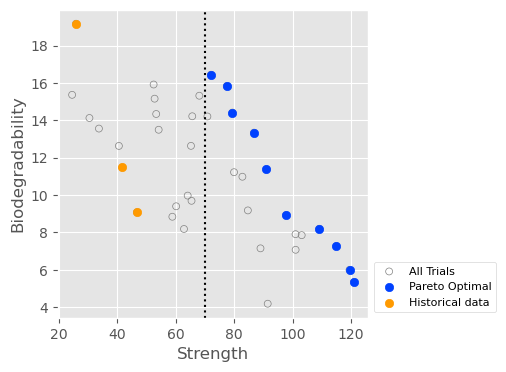

In [14]:
import matplotlib.pyplot as plt
plt.style.use("ggplot")

fig, ax = plt.subplots(figsize=(4, 4), dpi=100)

all_trials = ax_client.get_trials_data_frame()
ax.scatter(
    all_trials["strength"], 
    all_trials["biodegradability"], 
    color='#818180', 
    facecolor='none', 
    s=25,
    label='All Trials'
)
ax.scatter(pareto_results["strength"], pareto_results["biodegradability"], color='#0041FF', label='Pareto Optimal')
historical = np.array([[d['strength'][0], d['biodegradability'][0]] for d in y_train])
ax.scatter(historical[:,0], historical[:,1], color='#FF9A00', label='Historical data')
ax.axvline(70, ls=':', color='k')
ax.set_xlabel("Strength")
ax.set_ylabel("Biodegradability")
ax.legend(facecolor='w', fontsize=8, loc='center left', bbox_to_anchor=(1, 0.1))
plt.show()